# Pet Adoption
### Build a Machine Learning model that determines type and breed of the animal based on its physical atrributes and other factors

It is a multioutput multiclassification or multitask classification problem. You have to predict two labels: 'breed_catagory' and 'pet_catagory'.The evaluation metric is being used is(the average of both f1_scores * 100)

The best solution I got by implemeting is to train two models instead of using a single model which predicts the multi task calssification.
- Build one classification model and predict the output.
- Use the predicted output of 1st model as input feature to 2nd model.

## Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Model libraries
import xgboost as xgb


#Other Libraries
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler,MinMaxScaler
from feature_engine import categorical_encoders as ce
from sklearn.metrics import f1_score
import datetime as dt

## Exploring the data 

In [2]:
train = pd.read_csv('https://raw.githubusercontent.com/VijayMukkala/Mini-Projects/master/Pet%20Adoption/train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/VijayMukkala/Mini-Projects/master/Pet%20Adoption/test.csv')
print(train.shape)
train.head()

(18834, 11)


,pet_id,issue_date,listing_date,condition,color_type,length(m),height(cm),X1,X2,breed_category,pet_category
0,ANSL_69903,2016-07-10 00:00:00,2016-09-21 16:25:00,2.0,Brown Tabby,0.80,7.78,13,9,0.0,1
1,ANSL_66892,2013-11-21 00:00:00,2018-12-27 17:47:00,1.0,White,0.72,14.19,13,9,0.0,2
2,ANSL_69750,2014-09-28 00:00:00,2016-10-19 08:24:00,NaN,Brown,0.15,40.90,15,4,2.0,4
3,ANSL_71623,2016-12-31 00:00:00,2019-01-25 18:30:00,1.0,White,0.62,17.82,0,1,0.0,2
4,ANSL_57969,2017-09-28 00:00:00,2017-11-19 09:38:00,2.0,Black,0.50,11.06,18,4,0.0,1


### Column Description in detail
- 'issue_date' : Date on which the pet was issues to the shelter
- 'listing_date' : Date when the pet arrived at the shelter
- 'condition' : Condition of the pet
- 'color_type' : color of the pet
- 'length(m)' : Length of the pet(in meter)
- 'height(cm)' : Height of the pet (in cm)
- 'breed_category' : Breed Category of the pet
- 'pet_category' : Category of the pet

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18834 entries, 0 to 18833
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pet_id          18834 non-null  object 
 1   issue_date      18834 non-null  object 
 2   listing_date    18834 non-null  object 
 3   condition       17357 non-null  float64
 4   color_type      18834 non-null  object 
 5   length(m)       18834 non-null  float64
 6   height(cm)      18834 non-null  float64
 7   X1              18834 non-null  int64  
 8   X2              18834 non-null  int64  
 9   breed_category  18834 non-null  float64
 10  pet_category    18834 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 1.6+ MB


In [4]:
train.describe()

,condition,length(m),height(cm),X1,X2,breed_category,pet_category
count,17357.000000,18834.000000,18834.000000,18834.000000,18834.000000,18834.000000,18834.000000
mean,0.883390,0.502636,27.448832,5.369598,4.577307,0.600563,1.709143
std,0.770434,0.288705,13.019781,6.572366,3.517763,0.629883,0.717919
min,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.250000,16.172500,0.000000,1.000000,0.000000,1.000000
50%,1.000000,0.500000,27.340000,0.000000,4.000000,1.000000,2.000000
75%,1.000000,0.760000,38.890000,13.000000,9.000000,1.000000,2.000000
max,2.000000,1.000000,50.000000,19.000000,9.000000,2.000000,4.000000


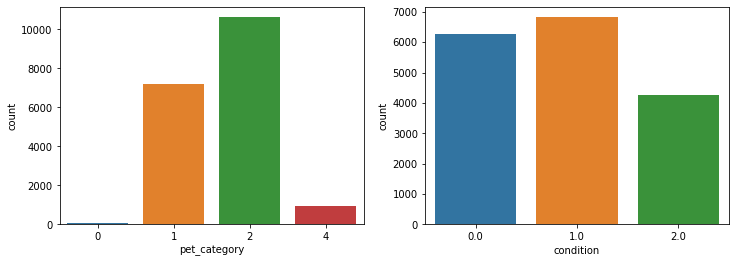

In [5]:
f, axes = plt.subplots(ncols=2, figsize=(12,4))
sns.countplot(train['pet_category'],ax=axes[0])
sns.countplot(train['condition'],ax=axes[1])
plt.show()

From the distribution of pet_category , we can see that the feature is imbalanced. We can apply undersampling or oversampling techniques or using bagging hyperparameters

### Checking for missing values in the data 

In [6]:
print(train.isnull().sum())
print(test.isnull().sum())

pet_id               0
issue_date           0
listing_date         0
condition         1477
color_type           0
length(m)            0
height(cm)           0
X1                   0
X2                   0
breed_category       0
pet_category         0
dtype: int64
pet_id            0
issue_date        0
listing_date      0
condition       619
color_type        0
length(m)         0
height(cm)        0
X1                0
X2                0
dtype: int64


__condition__ column has missing values both in train and test.

#### Missing Values imputation

Replace missing value with 99 and check for the pattern

In [7]:
train['condition'].fillna(99,inplace = True)
print(train['condition'].value_counts())

1.0     6819
0.0     6281
2.0     4257
99.0    1477
Name: condition, dtype: int64


In [8]:
train.groupby(['condition','pet_category']).size()

condition  pet_category
0.0        1               2376
           2               3875
           4                 30
1.0        1               2218
           2               4576
           4                 25
2.0        0                 37
           1               2007
           2               2110
           4                103
99.0       0                 51
           1                583
           2                 60
           4                783
dtype: int64

In [9]:
train.groupby(['condition','breed_category']).size()

condition  breed_category
0.0        1.0               6281
1.0        0.0               6819
2.0        0.0               2181
           1.0               2076
99.0       2.0               1477
dtype: int64

Looks like all the missing values belong to Breed_category 2 and we hit a jackpot

## Feature Engineering

### New feature creation from alphanumeric col pet_id

In [10]:
train['nf1_pet_id'] = train['pet_id'].str[:6]
train['nf2_pet_id'] = train['pet_id'].str[:7]

4
ANSL_6    7005
ANSL_5    6999
ANSL_7    4813
ANSL_4      17
Name: nf1_pet_id, dtype: int64


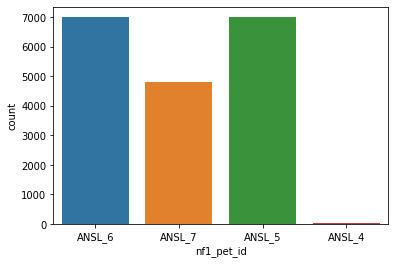

In [13]:
print(train.nf1_pet_id.nunique())
print(train.nf1_pet_id.value_counts())
sns.countplot(train['nf1_pet_id'])

In [12]:
print(train.nf2_pet_id.nunique())
print(train.nf2_pet_id.value_counts())

28
ANSL_61    739
ANSL_70    715
ANSL_52    714
ANSL_60    714
ANSL_55    712
ANSL_59    708
ANSL_73    708
ANSL_58    708
ANSL_72    705
ANSL_62    703
ANSL_67    702
ANSL_51    702
ANSL_56    700
ANSL_63    700
ANSL_64    699
ANSL_75    699
ANSL_57    699
ANSL_54    699
ANSL_66    695
ANSL_65    692
ANSL_68    691
ANSL_50    689
ANSL_74    682
ANSL_71    677
ANSL_69    670
ANSL_53    668
ANSL_76    627
ANSL_49     17
Name: nf2_pet_id, dtype: int64


### Creating multiple features using date features: issue_date & listing date

In [14]:
# New feature(Waiting time in Months) to find the difference between the issue date and the listing date 

train['issue_date'] = pd.to_datetime(train['issue_date']).apply(lambda x: x.date()) # removing the time values from the string columns
train['listing_date'] = pd.to_datetime(train['listing_date']).apply(lambda x: x.date()) # removing the time values from the string columns
train['Waiting_time(M)'] = (train['listing_date']- train['issue_date'])/np.timedelta64(1,'M') # difference of listing_date and issue_date in months
train['Waiting_time(M)'] = np.round(train['Waiting_time(M)'],2) # rounding of the value to 2 decimals


In [15]:
# Also creating new features from the issue date and listing date by converting their format into months
train['issue_date'] = pd.to_datetime(train['issue_date'])
train['issue_dt_month'] = train['issue_date'].dt.month 
train['listing_date'] = pd.to_datetime(train['listing_date'])
train['listing_dt_month'] = train['listing_date'].dt.month

#### Anomaly detection in the date features

In [16]:
train[train['Waiting_time(M)'] < 0]

,pet_id,issue_date,listing_date,condition,color_type,length(m),height(cm),X1,X2,breed_category,pet_category,nf1_pet_id,nf2_pet_id,Waiting_time(M),issue_dt_month,listing_dt_month
1504,ANSL_52243,2018-01-17,2018-01-14,2.0,Orange Tabby,0.72,43.19,13,9,0.0,1,ANSL_5,ANSL_52,-0.1,1,1
5301,ANSL_63737,2016-11-18,2016-09-03,0.0,Black,0.88,27.82,0,1,1.0,1,ANSL_6,ANSL_63,-2.5,11,9


As we know that the waiting time cannot be negative , we are gonna drop these rows

In [17]:
train = train.drop(train[train['Waiting_time(M)'] < 0].index)
train.shape

(18832, 16)

### Analyzing the "Length(m)" feature

In [18]:
train[train['length(m)'] == 0]['length(m)'].value_counts()

0.0    93
Name: length(m), dtype: int64

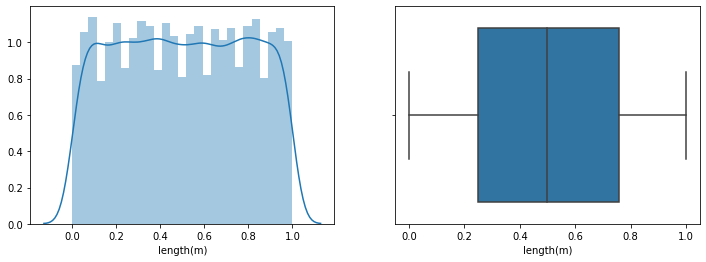

In [19]:
f, axes = plt.subplots(ncols=2, figsize=(12,4))
sns.distplot(train['length(m)'],ax=axes[0])
sns.boxplot(train['length(m)'],ax=axes[1])

From the above graphs we observe that few values are very less and actually zero.

After research in the google, the smallest pet is around 10 cm length it might be more than that but as we are not sure of the pet category except dog and cat , for this problem we will conider the length data for the pet more than 10cm is __anomaly__

In [20]:
# Converting length from 'm' to 'cm'

train['length(cm)'] = train['length(m)']*100

# Replacing values less than 10 cm with the mean value

for value in train['length(cm)']:
    if (value < 10):
        train['length(cm)'] = train['length(cm)'].replace(value, np.round(train['length(cm)'].mean()))

In [21]:
#Creating a new feature from lenght and height as ratio
train['ratio_len_height'] = train['length(cm)']/train['height(cm)']

### Creating new features from the "color_type" feature
Color_type feature has few key words like Tabby,brindle,tiger,etc which are categorized to one specific pet.

In [22]:
train['color_type'].unique()

array(['Brown Tabby', 'White', 'Brown', 'Black', 'Red', 'Tricolor',
       'Calico', 'Brown Brindle', 'Blue', 'Tortie', 'Gray', 'Fawn',
       'Buff', 'Torbie', 'Orange Tabby', 'Sable', 'Tan', 'Blue Tick',
       'Orange', 'Blue Tabby', 'Chocolate', 'Black Tabby',
       'Black Brindle', 'Cream Tabby', 'Gold', 'Calico Point',
       'Blue Merle', 'Red Merle', 'Yellow', 'Lynx Point', 'Blue Cream',
       'Flame Point', 'Cream', 'Yellow Brindle', 'Blue Tiger',
       'Seal Point', 'Red Tick', 'Brown Merle', 'Black Smoke',
       'Gray Tabby', 'Green', 'Tortie Point', 'Blue Smoke', 'Apricot',
       'Blue Point', 'Silver Tabby', 'Lilac Point', 'Silver',
       'Brown Tiger', 'Liver', 'Agouti', 'Chocolate Point', 'Liver Tick',
       'Pink', 'Black Tiger', 'Silver Lynx Point'], dtype=object)

In [23]:
train['color_type1'] = train['color_type']
train['color_type2'] = train['color_type']

Splitting the colour_type variable into two features which gives more information to predict the output

In [24]:
list = ['Brown','Blue','Black','Cream','Red','Calico','Yellow','Gray','Silver','Chocolate','Orange','Liver']
for val in train['color_type']:
    if (val.split()[0] in list) & (len(val.split())>1):     
        train['color_type1'] = train['color_type1'].replace(val,val.split()[0])
        train['color_type2'] = train['color_type2'].replace(val,val.split()[1])
        

## Feature enginneering and missing value imputation on the *test data* same as train

In [24]:
test['condition'].fillna(99,inplace = True)

In [25]:
test['nf1_pet_id'] = test['pet_id'].str[:6]
test['nf2_pet_id'] = test['pet_id'].str[:7]

In [26]:
test['issue_date'] = pd.to_datetime(test['issue_date']).apply(lambda x: x.date())
test['listing_date'] = pd.to_datetime(test['listing_date']).apply(lambda x: x.date())
test['Waiting_time(M)'] = (test['listing_date']- test['issue_date'])/np.timedelta64(1,'M')
test['Waiting_time(M)'] = np.round(test['Waiting_time(M)'],2)


In [27]:
# Also creating new features from the issue date and listing date by converting their format into months
test['issue_date'] = pd.to_datetime(test['issue_date'])
test['issue_dt_month'] = test['issue_date'].dt.month
test['listing_date'] = pd.to_datetime(test['listing_date'])
test['listing_dt_month'] = test['listing_date'].dt.month

In [28]:
test = test.drop(test[test['Waiting_time(M)'] < 0].index)

In [29]:
test['length(cm)'] = test['length(m)']*100

# Replacing values less than 10 cm with the mean value

for value in test['length(cm)']:
    if (value < 10):
        test['length(cm)'] = test['length(cm)'].replace(value, np.round(test['length(cm)'].mean()))

In [30]:
test['ratio_len_height'] = test['length(cm)']/test['height(cm)']

In [31]:
test['color_type1'] = test['color_type']
test['color_type2'] = test['color_type']

In [32]:
list = ['Brown','Blue','Black','Cream','Red','Calico','Yellow','Gray','Silver','Chocolate','Orange','Liver']
for val in test['color_type']:
    if (val.split()[0] in list) & (len(val.split())>1):     
        test['color_type1'] = test['color_type1'].replace(val,val.split()[0])
        test['color_type2'] = test['color_type2'].replace(val,val.split()[1])
        

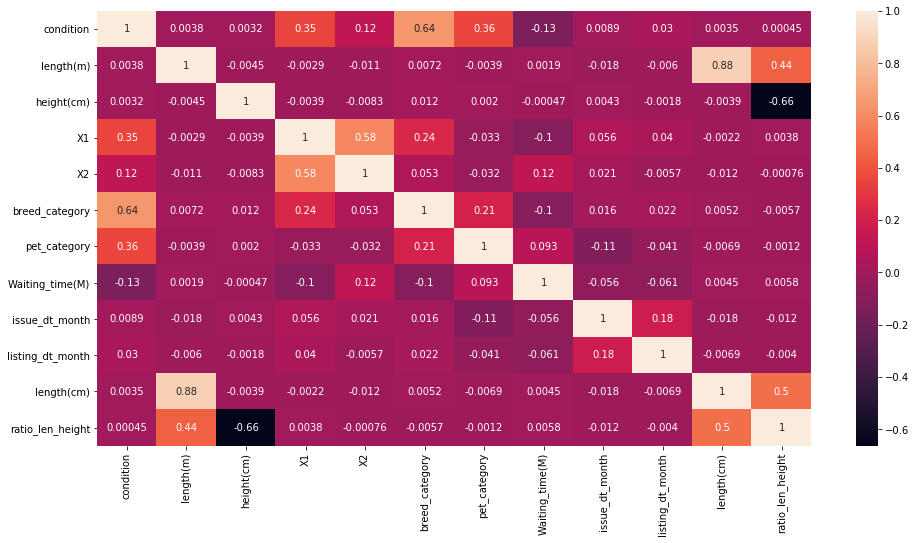

In [33]:
plt.subplots(figsize=(16,8))
sns.heatmap(train.corr(), annot= True)

### Summary:

- Missing value imputation done by replacing the nan with 99
- created 2 new features from apla numeric column pet_id
- Created new features from the date columns 'issue_date' & 'listing_date'
- Checked the anomaly with the date columns and dropped the rows
- Converted the length column from 'm' to 'cm' and replaced values less than 10cm with the mean value
- Created new feature from length and height columns
- Created 2 color_type columns by splitting the values 


### To do in modelling
- Cross validation
- Standardizing the categorical variables
- Use onehot encoding on the categorical variables
- Droping the columns
- Fit the data to a hypertuned model with target value as 'pet_category'
- Create another hypertuned model with the values from previous model and predict 'breed_category' feature

### Creating X & y variables

In [34]:
X1 = train.drop(['breed_category','pet_category'], axis=1)
y1 = train['pet_category']
X2 = train.drop(['breed_category'], axis=1)
y2 = train['breed_category']

In [35]:
print(X1.shape)
print(y1.shape)
X1.head()

(18832, 18)
(18832,)


,pet_id,issue_date,listing_date,condition,color_type,length(m),height(cm),X1,X2,nf1_pet_id,nf2_pet_id,Waiting_time(M),issue_dt_month,listing_dt_month,length(cm),ratio_len_height,color_type1,color_type2
0,ANSL_69903,2016-07-10,2016-09-21,2.0,Brown Tabby,0.80,7.78,13,9,ANSL_6,ANSL_69,2.40,7,9,80.0,10.282776,Brown,Tabby
1,ANSL_66892,2013-11-21,2018-12-27,1.0,White,0.72,14.19,13,9,ANSL_6,ANSL_66,61.18,11,12,72.0,5.073996,White,White
2,ANSL_69750,2014-09-28,2016-10-19,99.0,Brown,0.15,40.90,15,4,ANSL_6,ANSL_69,24.71,9,10,15.0,0.366748,Brown,Brown
3,ANSL_71623,2016-12-31,2019-01-25,1.0,White,0.62,17.82,0,1,ANSL_7,ANSL_71,24.81,12,1,62.0,3.479237,White,White
4,ANSL_57969,2017-09-28,2017-11-19,2.0,Black,0.50,11.06,18,4,ANSL_5,ANSL_57,1.71,9,11,50.0,4.520796,Black,Black


### Model 1 

In [36]:
from sklearn.model_selection import train_test_split,cross_val_score
X_train1, X_test1, y_train1,y_test1 = train_test_split(X1,y1,test_size = 0.25, random_state = 42,stratify = y1)
print("Train size :" ,X_train1.shape,y_train1.shape)
print("Test size :"  ,X_test1.shape, y_test1.shape)

Train size : (14124, 18) (14124,)
Test size : (4708, 18) (4708,)


In [37]:
X_train1.head()

,pet_id,issue_date,listing_date,condition,color_type,length(m),height(cm),X1,X2,nf1_pet_id,nf2_pet_id,Waiting_time(M),issue_dt_month,listing_dt_month,length(cm),ratio_len_height,color_type1,color_type2
12872,ANSL_75136,2016-03-07,2019-03-27,2.0,Tan,0.97,48.81,0,7,ANSL_7,ANSL_75,36.63,3,3,97.0,1.987298,Tan,Tan
6982,ANSL_63101,2011-11-03,2017-11-24,1.0,White,0.42,42.37,0,7,ANSL_6,ANSL_63,72.71,11,11,42.0,0.991267,White,White
6398,ANSL_58252,2017-05-27,2017-08-13,2.0,Cream Tabby,0.43,35.09,0,1,ANSL_5,ANSL_58,2.56,5,8,43.0,1.225420,Cream,Tabby
14018,ANSL_75197,2014-11-01,2016-11-23,2.0,Brown Tabby,0.74,46.37,16,9,ANSL_7,ANSL_75,24.74,11,11,74.0,1.595859,Brown,Tabby
8946,ANSL_73710,2016-05-02,2017-01-22,2.0,Brown,1.00,36.53,0,7,ANSL_7,ANSL_73,8.71,5,1,100.0,2.737476,Brown,Brown


The features for the model is selected using feature selection of univariate features by Annova method

In [38]:
numerical_features1 = ['Waiting_time(M)','ratio_len_height']
numerical_features2 = ['X1','X2']
categorical_features = ['condition','nf1_pet_id','issue_dt_month','listing_dt_month','color_type1','color_type2']

### Building custom Transformer 

- scaling on numerical_featuures1
- Normalizing on numerical_features2
- onehotencoding on the categorical features
- dropping the columns not important for model

In [39]:
numeric_transformer1 = Pipeline(steps=[
    ('scaler', RobustScaler())
])

numeric_transformer2 = Pipeline(steps=[
    ('normalizer',MinMaxScaler())
])

category_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  
])


In [40]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers = [
        ('drop_columns', 'drop', ['pet_id','issue_date','listing_date','length(m)','color_type','nf2_pet_id','length(cm)','height(cm)',]),
        ('numeric1', numeric_transformer1,numerical_features1),
        ('numeric2', numeric_transformer2,numerical_features2),
        ('category', category_transformer, categorical_features)
])

### Fitting the transform operations on train and transforming on train and test

In [41]:
preprocessor.fit(X_train1)

ColumnTransformer(transformers=[('drop_columns', 'drop',
                                 ['pet_id', 'issue_date', 'listing_date',
                                  'length(m)', 'color_type', 'nf2_pet_id',
                                  'length(cm)', 'height(cm)']),
                                ('numeric1',
                                 Pipeline(steps=[('scaler', RobustScaler())]),
                                 ['Waiting_time(M)', 'ratio_len_height']),
                                ('numeric2',
                                 Pipeline(steps=[('normalizer',
                                                  MinMaxScaler())]),
                                 ['X1', 'X2']),
                                ('category',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['condition', 'nf1_pet_id', 'issue_dt_month',
                            

In [42]:
X_train1 = preprocessor.transform(X_train1)
X_test1 = preprocessor.transform(X_test1)

In [43]:
X_train1.shape

(14124, 104)

### Xgboost

In [44]:
import xgboost as xgb
from sklearn.metrics import f1_score
xgb_model = xgb.XGBClassifier(scale_pos_weight = 0.7,
min_child_weight=  3,
learning_rate = 0.3,
gamma = 0.4,
colsample_bytree = 0.5, random_state = 42)
xgb_model.fit(X_train1, y_train1)
y_pred_xgb = xgb_model.predict(X_test1)

s1 = f1_score(y_test1,y_pred_xgb,average = 'weighted')
print(s1)

0.9084208351982886


### Hyper tuning the parameters for the best result:

Best parameters in this case :
(scale_pos_weight = 0.7,
min_child_weight=  3,
learning_rate = 0.3,
gamma = 0.4,
colsample_bytree = 0.5)


### Applying the transformer on the test data and predicting the target variable 'pet_category'

In [45]:
test1 = test
test1 = preprocessor.transform(test1)

In [46]:
X1 = preprocessor.transform(X1)

In [47]:
xgb_model = xgb.XGBClassifier(scale_pos_weight = 0.7,
min_child_weight=  3,
learning_rate = 0.3,
gamma = 0.4,
colsample_bytree = 0.5)
xgb_model.fit(X1, y1)
prediction1 = xgb_model.predict(test1)


In [48]:
predicted_values1 = pd.DataFrame(prediction1, columns = ['pet_category'])

In [49]:
predicted_values1

,pet_category
0,2
1,1
2,2
3,2
4,2
...,...
8067,2
8068,2
8069,2
8070,4


### Model 2 

In [50]:
from sklearn.model_selection import train_test_split
X_train2, X_test2, y_train2,y_test2 = train_test_split(X2,y2,test_size = 0.25, random_state = 42, stratify = y2)
print("Train size :" ,X_train2.shape,y_train2.shape)
print("Test size :"  ,X_test2.shape, y_test2.shape)

Train size : (14124, 19) (14124,)
Test size : (4708, 19) (4708,)


In [51]:
X_train2.head(2)

,pet_id,issue_date,listing_date,condition,color_type,length(m),height(cm),X1,X2,pet_category,nf1_pet_id,nf2_pet_id,Waiting_time(M),issue_dt_month,listing_dt_month,length(cm),ratio_len_height,color_type1,color_type2
18776,ANSL_52947,2008-12-20,2018-05-21,1.0,Brown,0.69,20.88,7,1,2,ANSL_5,ANSL_52,112.99,12,5,69.0,3.304598,Brown,Brown
11881,ANSL_53011,2018-06-12,2019-02-14,1.0,Black,0.52,48.00,0,1,1,ANSL_5,ANSL_53,8.12,6,2,52.0,1.083333,Black,Black


In [52]:
numerical_features3 = ['Waiting_time(M)','length(cm)','height(cm)']
numerical_features4= ['X1','X2']
categorical_features1 = ['condition','color_type1','color_type2','pet_category','listing_dt_month']#,'nf1_pet_id','nf2_pet_id','issue_dt_month',,'listing_dt_month'


### Building custom Transformer 

- scaling on numerical_featuures1
- Normalizing on numerical_features2
- onehotencoding on the categorical features
- dropping the columns not important for model

In [53]:
numeric_transformer3 = Pipeline(steps=[
    ('scaler1', RobustScaler())
])

numeric_transformer4 = Pipeline(steps=[
    ('normalizer1',MinMaxScaler())
])

category_transformer1 = Pipeline(steps=[
    ('onehot1', OneHotEncoder(handle_unknown='ignore'))  
])


from sklearn.compose import ColumnTransformer

preprocessor1 = ColumnTransformer(
    transformers = [
        ('drop_columns', 'drop', ['pet_id','issue_date','listing_date','length(m)','color_type','nf1_pet_id','nf2_pet_id','issue_dt_month']),#,'issue_dt_month','nf2_pet_id','nf1_pet_id'
        ('numeric3', numeric_transformer3,numerical_features3),
        ('numeric4', numeric_transformer4,numerical_features4),
        ('category', category_transformer1, categorical_features1)

])

### Fitting the transform operations on train and transforming on train and test

In [54]:
preprocessor1.fit(X_train2)

ColumnTransformer(transformers=[('drop_columns', 'drop',
                                 ['pet_id', 'issue_date', 'listing_date',
                                  'length(m)', 'color_type', 'nf1_pet_id',
                                  'nf2_pet_id', 'issue_dt_month']),
                                ('numeric3',
                                 Pipeline(steps=[('scaler1', RobustScaler())]),
                                 ['Waiting_time(M)', 'length(cm)',
                                  'height(cm)']),
                                ('numeric4',
                                 Pipeline(steps=[('normalizer1',
                                                  MinMaxScaler())]),
                                 ['X1', 'X2']),
                                ('category',
                                 Pipeline(steps=[('onehot1',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['condition', 'color_type

In [55]:
X_train2 = preprocessor1.transform(X_train2)
X_test2 = preprocessor1.transform(X_test2)

### Xgboost

In [56]:
import xgboost as xgb
xgb_model2 = xgb.XGBClassifier(scale_pos_weight = 8,
 min_child_weight = 1,
 learning_rate = 0.01,
 gamma= 0.3,
 colsample_bytree = 0.3, 
 random_state = 42)
xgb_model2.fit(X_train2, y_train2)
y_pred_xgb2= xgb_model2.predict(X_test2)

s2 = f1_score(y_test2,y_pred_xgb2,average = 'weighted')
print(s2)

0.906196841800934


In [57]:
score = (s1+s2) * 100/2
print('final_score on the train set',score)

final_score on the train set 90.73088384996113


### Hyper tuning the parameters for the best result for Model2 :
scale_pos_weight = 8,
 min_child_weight = 1,
 learning_rate = 0.01,
 gamma= 0.3,
 colsample_bytree = 0.3

In [58]:
### Applying the transformer on the test data and predicting the target variable 'breed_category'

In [59]:
X2_1 = X2.pop('pet_category')
X2['pet_category'] = X2_1 # to have the pet_category at the last same as test data 
preprocessor1.fit(X2)
X2 = preprocessor1.transform(X2)

In [60]:
test2 = test
test2['pet_category'] = predicted_values1['pet_category']


In [61]:
test2.head(2)

,pet_id,issue_date,listing_date,condition,color_type,length(m),height(cm),X1,X2,nf1_pet_id,nf2_pet_id,Waiting_time(M),issue_dt_month,listing_dt_month,length(cm),ratio_len_height,color_type1,color_type2,pet_category
0,ANSL_75005,2005-08-17,2017-09-07,0.0,Black,0.87,42.73,0,7,ANSL_7,ANSL_75,144.69,8,9,87.0,2.036040,Black,Black,2
1,ANSL_76663,2018-11-15,2019-05-08,1.0,Orange Tabby,0.06,6.71,0,1,ANSL_7,ANSL_76,5.72,11,5,51.0,7.600596,Orange,Tabby,1


In [62]:
test2 = preprocessor1.transform(test2)

In [63]:
xgb_model2 = xgb.XGBClassifier(scale_pos_weight = 8,
 min_child_weight = 1,
 learning_rate = 0.01,
 gamma= 0.3,
 colsample_bytree = 0.3)
xgb_model2.fit(X2, y2)
prediction2= xgb_model2.predict(test2)

In [64]:
predicted_values2 = pd.DataFrame(prediction2, columns = ['breed_category'])

In [65]:
predicted_values2

,breed_category
0,1.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
8067,0.0
8068,1.0
8069,1.0
8070,2.0


### Submission_format

In [66]:
output=pd.DataFrame({"pet_id":test["pet_id"],"breed_category":predicted_values2['breed_category'],'pet_category':predicted_values1["pet_category"]}) 

In [67]:
output.to_csv(path_or_buf="submission82.csv",index=False,quoting=3)

In [68]:
output

,pet_id,breed_category,pet_category
0,ANSL_75005,1.0,2
1,ANSL_76663,0.0,1
2,ANSL_58259,0.0,2
3,ANSL_67171,0.0,2
4,ANSL_72871,0.0,2
...,...,...,...
8067,ANSL_66809,0.0,2
8068,ANSL_59041,1.0,2
8069,ANSL_60034,1.0,2
8070,ANSL_58066,2.0,4


Achieved __91.029 score__ on the __unseen test__ data using the approach of training two models.
- Building one classification model and predicting the output.
- Using the predicted output of 1st model as input feature to 2nd model.